# Machine Learning Pipeline - Feature Selection

In the following notebooks, we will go through the implementation of each of the steps in the Machine Learning Pipeline.

We will discuss:

1. Data Analysis
2. Feature Engineering
3. **Feature Selection**
4. Model Training
5. Obtaining Predictions / Scoring

Our selection procedure will be focused solely on non-parametric statistical methods because they are model-agnostic. We avoid model-specific methods because:

1. They can be very computationally expensive. This project is being run on a local machine and not a distrubuted system.
2. Model-specific methods would require us to use the same model in training as we did in feature selection for consistency. This is impractical as we still have to run our data through a range of options during training before deciding on our most optimal model.

In [1]:
# to handle datasets
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
# to run statistical tests
from scipy.stats import kruskal, mannwhitneyu, spearmanr

In [3]:
# to visualise all the columns in the dataframe
pd.pandas.set_option('display.max_columns',None)

In [4]:
# load the train and test sets with the engineered variables
X_train = pd.read_csv('xtrain_unscaled.csv')
X_test = pd.read_csv('xtest_unscaled.csv')

In [5]:
# drop the rank feature - it is unneeded
X_train = X_train.drop('rank',axis=1)

In [6]:
# visualise the dataframe
X_train.head()

,age,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,16,4,2,3,5,4,3,1,2,0,4,5,1,1,3,5,2,0,1,1,1,1,0,0,0,1,1,1,1,0
1,17,4,4,3,5,4,3,2,2,0,3,3,3,2,3,4,2,0,1,0,1,0,0,1,1,0,1,1,1,0
2,16,2,4,5,2,4,2,2,2,0,4,2,2,1,2,5,2,0,0,1,1,1,0,1,1,1,1,1,1,1
3,16,2,2,4,5,3,3,2,2,0,3,4,4,1,4,5,2,0,0,1,0,1,0,0,1,1,0,1,1,0
4,16,1,2,5,5,4,3,2,1,1,4,4,4,2,4,5,0,0,1,1,1,1,0,0,0,1,1,1,0,0


In [7]:
# load the target
y_train = pd.read_csv('ytrain.csv')
y_test = pd.read_csv('ytest.csv')

In [8]:
# visualise the target
y_train.head()

,G3
0,16
1,12
2,13
3,11
4,0


# Feature Selection

Let's go ahead and select a subset of the most predictive features.

## Drop constant features
Constant features show the same value for all observations in the dataset and provide no information value for a machine learning model. As a sanity check, we will check all our variables for constant features and remove them.

In [9]:
constant_features = [feat for feat in X_train.columns if X_train[feat].nunique() == 1]
constant_features

[]

We have no variables with constant values in the dataset.

## Drop quasi-constant features

Quasi-constant features also show the same value but only for the great majority of the observations. Like constant features, they provide little, if any, information value for any model to work with.

As another canity check, we will also check all our columsn for quasi-consyant features and remove them.

In [10]:
# creat an empty list
quasi_constant_feat = []

# iterate over every feature
for feature in X_train.columns:
    
    # find the predominant value, i.e. the value shared
    # by most observations
    predominant = (X_train[feature].value_counts() / float(
        len(X_train))).sort_values(ascending=False).values[0]
    
    # evaluate the predominant feature: do more than 99% of the observations
    # show 1 value?
    if predominant > 0.998:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

In [11]:
len(quasi_constant_feat)

0

Our dataset does not have any variables with quasi-constant values.

## Drop correlated features

Good feature subsets contain features highly correlated with the target but uncorrelated with each other. Let's identify independent variables highly correlated with themselves.

We use the Spearman rank-order correlation using rank values instead of real values considering the non-parametric nature of our target.

In [12]:
corrmat = X_train.corr(method='spearman')

<AxesSubplot:>

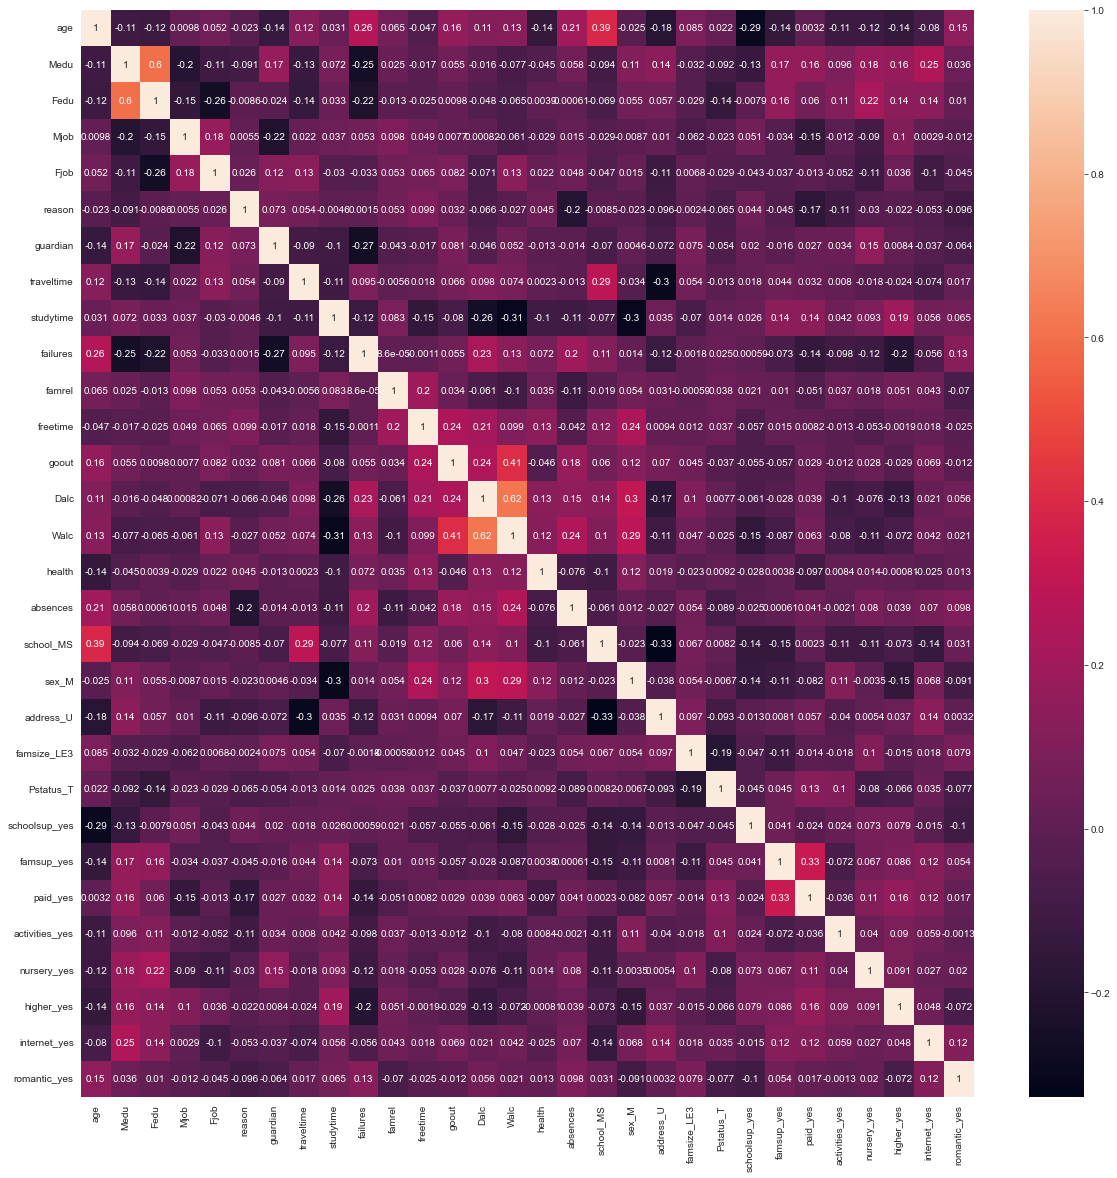

In [13]:
plt.figure(figsize=(20,20))
sns.heatmap(corrmat,annot=True)

In [14]:
# pick out variable pairs with correlation coeeficients > 80%
# and < 1 to exclude variables self-correlating

corrmat = corrmat.abs().unstack()
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1','feature2','corr']
corrmat.head()

,feature1,feature2,corr


We have no independent variables highly correlated with other independent variables.

## Statistical Tests
We will now evaluate our variables individually to select variables with a strong predictive association with our target. This process will involve non-parametric model-agnostic methods for the three distinct variable types in our dataset.

- Categorical Variables
- Discrete Variables
- Continuous Variables

### Categorical Variables: Mann-Whitney U Test
For the categorical binary variables, we will test for parity in sample distributions at the 5% significance level. 

- **NULL HYPOTHESIS (H0):** Samples from the categorical variables are drawn from the same distribution.
- **ALTERNATIVE HYPOTHESIS (H1):** Samples from the categorical variables are drawn from different distributions.

In [15]:
# list out the categorical variables
cat_vars = ['school_MS',
            'sex_M',
            'address_U',
            'famsize_LE3',
            'Pstatus_T',
            'schoolsup_yes',
            'famsup_yes',
            'paid_yes',
            'activities_yes',
            'nursery_yes',
            'higher_yes',
            'internet_yes',
            'romantic_yes']

In [16]:
# print out the labels for each variable
for var in cat_vars:
    print(f'{var}: {X_train[var].unique()}')

school_MS: [0 1]
sex_M: [1 0]
address_U: [1 0]
famsize_LE3: [1 0]
Pstatus_T: [1 0]
schoolsup_yes: [0 1]
famsup_yes: [0 1]
paid_yes: [0 1]
activities_yes: [1 0]
nursery_yes: [1 0]
higher_yes: [1 0]
internet_yes: [1 0]
romantic_yes: [0 1]


<AxesSubplot:>

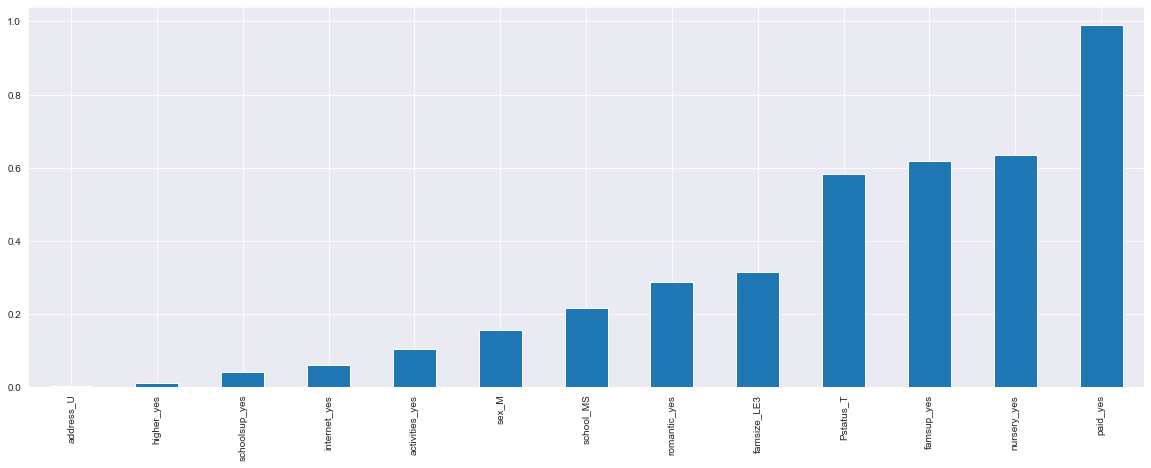

In [17]:
# concat the train label with the variables
train = pd.concat([X_train,y_train],axis=1)

# create an empty dictionary
p_ls = {}

# iterate over each binary feature
for feat in cat_vars:
    
    # separate the binary distributions
    class_0 = train[train[feat]==0]['G3']
    class_1 = train[train[feat]==1]['G3']
    
    # run the test and store the p values in the dict
    stat, p = mannwhitneyu(class_0,class_1)
    p_ls[feat] = p

# plot out the p values
p_ls = pd.Series(p_ls)
p_ls.sort_values(ascending=True).plot.bar(figsize=(20,7))

In [18]:
# print out the p values
p_ls.sort_values(ascending=True)

address_U         0.002137
higher_yes        0.010932
schoolsup_yes     0.040570
internet_yes      0.061159
activities_yes    0.105254
sex_M             0.156450
school_MS         0.216739
romantic_yes      0.288807
famsize_LE3       0.315929
Pstatus_T         0.582412
famsup_yes        0.617120
nursery_yes       0.633547
paid_yes          0.990898
dtype: float64

Let's go ahead and select the features that violate the null hypothesis at the 5% significance level.

In [19]:
selected_features = [feat for feat in p_ls.keys() if p_ls[feat] <= 0.05]
selected_features

['address_U', 'schoolsup_yes', 'higher_yes']

Of course, the degree of association between the selected variables and the target would ultimately be decided by an effect size computation. Let's now create a function that can compute the effect sizes of the selected variables.

In [20]:
def mw_effect_size(df, feat, target):
    
    # separate the two samples
    class_0 = df[df[feat]==0][target]
    class_1 = df[df[feat]==1][target]
    
    # grab the p-values and the statistic
    U1, p = mannwhitneyu(class_0,class_1)
    nx, ny = len(class_0), len(class_1)
    
    # find the z-score
    U2 = (nx*ny) - U1
    U = min(U1,U2)
    N = nx + ny
    z = (U - nx*ny/2 + 0.5) / np.sqrt(nx*ny * (N + 1)/ 12)
    
    # compute the effect size
    r = z / np.sqrt(N)
    return r

<AxesSubplot:>

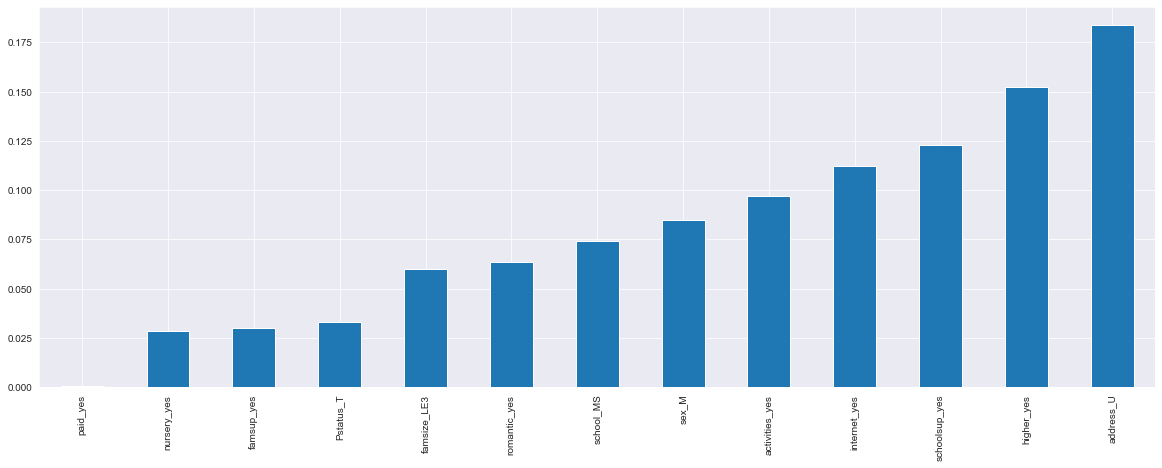

In [21]:
# empty dict to store the sizes
sizes = {}

# iterate over each variable
for var in cat_vars:
    
    # store the size and variable name in the dictionary
    size = mw_effect_size(train,var,'G3')
    sizes[var] = abs(size)

# plot out the sizes in ascending order
sizes = pd.Series(sizes)
sizes.sort_values(ascending=True).plot.bar(figsize=(20,7))

In [22]:
sizes.sort_values(ascending=True)

paid_yes          0.000683
nursery_yes       0.028563
famsup_yes        0.029953
Pstatus_T         0.032945
famsize_LE3       0.060085
romantic_yes      0.063553
school_MS         0.074008
sex_M             0.084905
activities_yes    0.097054
internet_yes      0.112179
schoolsup_yes     0.122697
higher_yes        0.152473
address_U         0.183963
dtype: float64

As expected, our three selected variables have the largest effect sizes of the group even though they all have small effects (<0.3). Lower p-values do not always indicate stronger effect sizes/relationships. We can now expect their predictive power to be limited during model training. 

### Discrete Variables: Kruskal-Wallis H Test

We consider the discrete variables as categorical variables because of their low 'cardinality'. Just like the categorical binary variables, we will also test for parity in at least one sample distribution at the 5% significance level.

- **NULL HYPOTHESIS (H0):** All data samples were drawn from the same distribution.
- **ALTERNATIVE HYPOTHESIS (H1):** At least one sample was drawn from a different distribution.

In [23]:
# print out the discrete variables
# isolate 'absences' since it is continuous

discrete_vars = [feat for feat in X_train.columns if feat not in cat_vars and feat != 'absences']
discrete_vars

['age',
 'Medu',
 'Fedu',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health']

Let's print out the number of unique categories present in each discrete variable:

In [24]:
for feat in discrete_vars:
    print(f'{feat}: {X_train[feat].nunique()}')

age: 8
Medu: 5
Fedu: 4
Mjob: 5
Fjob: 5
reason: 4
guardian: 3
traveltime: 4
studytime: 4
failures: 4
famrel: 5
freetime: 5
goout: 5
Dalc: 5
Walc: 5
health: 5


Our test will be run on variables with 8, 5, 4 and 3 different samples.

In [25]:
# create an empty dictionary
p_ls = {}
effect_sizes = {}

# iterate over the features
for feat in discrete_vars:
    
    # store the categories if the variable in a list
    categories = train[feat].value_counts().index.to_list()
    
    # create an empty list to store the samples from the categories
    samples = []
    
    # iterate over the categories
    # and append each category sample to the list
    for label in categories:
        samples.append(train[train[feat]==label]['G3'])
    
    # group/rename the samples for the variables with 8 categories
    # run the kruskal operation and store the p values in the empty dictionary
    if len(samples) == 8:
        class_1 = samples[0]
        class_2 = samples[1]
        class_3 = samples[2]
        class_4 = samples[3]
        class_5 = samples[4]
        class_6 = samples[5]
        class_7 = samples[6]
        class_8 = samples[7]
        stat,p = kruskal(class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8)
        p_ls[feat] = p
        n = len(train)
        H = stat
        eta_sq = H / (((n**2)-1) / (n+1))
        effect_sizes[feat] = eta_sq
    
    # group/rename the samples for the variables with 5 categories
    # run the kruskal operation and store the p values in the empty dictionary
    elif len(samples) == 5:
        class_1 = samples[0]
        class_2 = samples[1]
        class_3 = samples[2]
        class_4 = samples[3]
        class_5 = samples[4]
        stat,p = kruskal(class_1,class_2,class_3,class_4,class_5)
        p_ls[feat] = p
        n = len(train)
        H = stat
        eta_sq = H / (((n**2)-1) / (n+1))
        effect_sizes[feat] = eta_sq
    
    # group/rename the samples for the variables with 4 categories
    # run the kruskal operation and store the p values in the empty dictionary
    elif len(samples) == 4:
        class_1 = samples[0]
        class_2 = samples[1]
        class_3 = samples[2]
        class_4 = samples[3]
        stat,p = kruskal(class_1,class_2,class_3,class_4)
        p_ls[feat] = p
        n = len(train)
        H = stat
        eta_sq = H / (((n**2)-1) / (n+1))
        effect_sizes[feat] = eta_sq
    
    # group/rename the samples for the variables with 3 categories
    # run the kruskal operation and store the p values in the empty dictionary
    else:
        class_1 = samples[0]
        class_2 = samples[1]
        class_3 = samples[2]
        stat,p = kruskal(class_1,class_2,class_3)
        p_ls[feat] = p
        n = len(train)
        H = stat
        eta_sq = H / (((n**2)-1) / (n+1))
        effect_sizes[feat] = eta_sq

<AxesSubplot:>

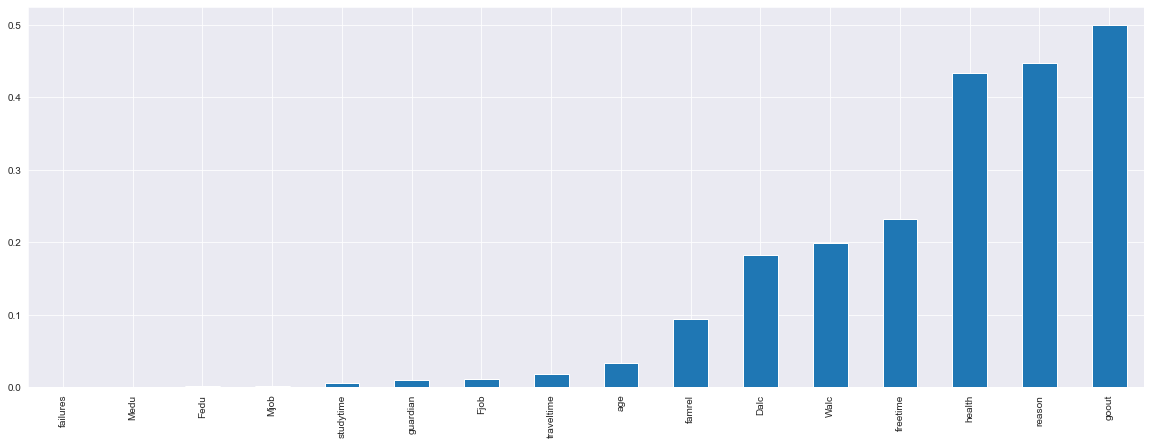

In [26]:
# plot out the p_values in ascending order
p_ls = pd.Series(p_ls)
p_ls.sort_values(ascending=True).plot.bar(figsize=(20,7))

In [27]:
# print out the p values
p_ls.sort_values(ascending=True)

failures      0.000002
Medu          0.000399
Fedu          0.001236
Mjob          0.001716
studytime     0.006055
guardian      0.010540
Fjob          0.010603
traveltime    0.017719
age           0.033115
famrel        0.093922
Dalc          0.182624
Walc          0.199028
freetime      0.232453
health        0.433162
reason        0.447409
goout         0.499730
dtype: float64

Let's go ahead and select the features that violate the null hypothesis at the 5% significance level. We will add the features to our existing list of selected features.

In [28]:
selected_features = selected_features + [feat for feat in p_ls.keys() if p_ls[feat] <= 0.05]

# print out the selected features
selected_features

['address_U',
 'schoolsup_yes',
 'higher_yes',
 'age',
 'Medu',
 'Fedu',
 'Mjob',
 'Fjob',
 'guardian',
 'traveltime',
 'studytime',
 'failures']

Like we did for the binary variables, we will compute and observe the effect sizes of the variables with particular emphasis on the features that have violated our null hypothesis.

<AxesSubplot:>

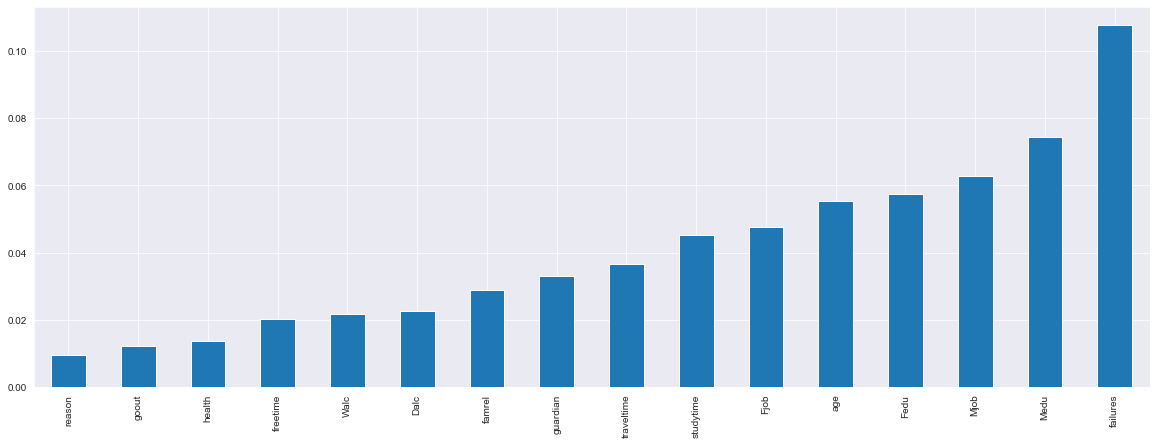

In [29]:
effect_sizes = pd.Series(effect_sizes)
effect_sizes.sort_values(ascending=True).plot.bar(figsize=(20,7))

In [30]:
effect_sizes.sort_values(ascending=True)

reason        0.009666
goout         0.012212
health        0.013833
freetime      0.020305
Walc          0.021824
Dalc          0.022654
famrel        0.028861
guardian      0.033110
traveltime    0.036734
studytime     0.045189
Fjob          0.047788
age           0.055396
Fedu          0.057515
Mjob          0.062785
Medu          0.074513
failures      0.107815
dtype: float64

In [31]:
effect_sizes.index

Index(['age', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian',
       'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout',
       'Dalc', 'Walc', 'health'],
      dtype='object')

In [32]:
small = []
moderate = []
large = []

for feature,value in zip(effect_sizes.index,effect_sizes.values):
    
    if value < 0.06:
        small.append(feature)
    elif (value >= 0.06) & (value < 0.14):
        moderate.append(feature)
    else:
        large.append(feature)
        
print(f'Number of features with small effects: {len(small)}')
print(f'Number of features with moderate effects: {len(moderate)}')
print(f'Number of features with large effects: {len(large)}')

Number of features with small effects: 13
Number of features with moderate effects: 3
Number of features with large effects: 0


None of the variables, including the selected features, shows a large effect size. We can thus expect the predicitive power of the selected features to be limited during training. 

What isn't surprising is that failures has the highest effect of the group. This pattern is intuitive - students with past class failures are usually expected to not perform well. However, failures just has a moderate effect size. This can be a good thing if students with past failures pick up the slack and improve their performance while good students maintain pace or even get better.

### Continuous Variables: Spearman's Rank Correlation

Finally, we will measure association with the target for the only continuous variable in the feature space. Before running the test, let's run a scatterplot of the two variables to get an eye-test of the relationship.

Text(0, 0.5, 'G3')

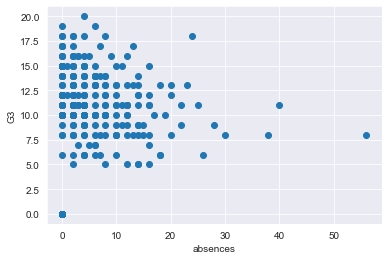

In [33]:
plt.scatter(x='absences',y='G3',data=train)
plt.xlabel('absences')
plt.ylabel('G3')

The plot reveals no observable or monotonic relationship between absences and grade performance. We would expect low scores with high absences when you consider attendance would typically be required to learn the course material but this isn't the case in this dataset.

Let's see if our test can confirm this.

- **NULL HYPOTHESIS (H0):** The correlation coefficient is 0.
- **ALTERNATIVE HYPOTHESIS (H1):** The correlation coefficient is not 0.

The test is conducted at the 5% significance level.

In [34]:
coef, p = spearmanr(train['absences'],train['G3'])

In [35]:
print(f'Correlation Coefficient: {coef}')
print(f'P Value: {p}')

Correlation Coefficient: -0.08338611493710343
P Value: 0.16714556416190085


Our p-value is bigger than alpha so we **fail to reject** the null hypothesis and conclude that there is no predictive association between 'absences' and 'G3'. It turns out you could miss a couple of classes and still pass the course with a pretty high grade.

In [36]:
# save our selected features for the next notebook
print(selected_features)
pd.Series(selected_features).to_csv('selected_features.csv', index=False)

['address_U', 'schoolsup_yes', 'higher_yes', 'age', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'guardian', 'traveltime', 'studytime', 'failures']


We can conclude by saying based on our statistical tests, our feature space is limited in predicting student performance.